In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import PIL
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#Tensorflow libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# import NN layers and other componenets.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import regularizers


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#keras libraries
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#other relevant libraries
import itertools
import matplotlib.pyplot as plt

#ignore warnings signs
import warnings
warnings.filterwarnings('ignore')

#importing sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,f1_score
import sklearn.metrics as metrics
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#loading the dataset
artists = pd.read_csv('artists.csv')

In [3]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 190 paintings
artists_top = artists[artists['paintings'] >= 190].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top


,name,paintings,class_weight
0,Vincent van Gogh,877,0.411017
1,Edgar Degas,702,0.513478
2,Pablo Picasso,439,0.821097
3,Pierre-Auguste Renoir,336,1.072802
4,Albrecht Dürer,328,1.098968
5,Paul Gauguin,311,1.159040
6,Francisco Goya,291,1.238699
7,Rembrandt,262,1.375807
8,Alfred Sisley,259,1.391743
9,Titian,255,1.413575


In [4]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights


{0: 0.41101657749320236,
 1: 0.5134779750164365,
 2: 0.8210968985456457,
 3: 1.0728021978021978,
 4: 1.0989681050656661,
 5: 1.1590403165965868,
 6: 1.238699444885012,
 7: 1.375807398708162,
 8: 1.3917433917433917,
 9: 1.4135746606334842,
 10: 1.5082072738976504,
 11: 1.858049167327518,
 12: 1.8676763650856916}

In [5]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [6]:
#names of artist after cleaning the dataset
artists_top_name = artists_top['name'].str.replace(' ', '_').values
print(artists_top_name.tolist())

['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Dürer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall', 'Rene_Magritte', 'Amedeo_Modigliani']


In [7]:
#defining batch size, shape and number: of class
batch_size = 70
train_input_shape = (100, 100, 3)
IMG_HEIGHT, IMG_WIDTH = 100, 100
n_classes = artists_top.shape[0]
images_dir="Data/images"

#Defining the pre-processing values for the images in the dataset
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

#Spliting train data
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes= artists_top_name.tolist()
                                                   )
#Splitting validate and testing data
valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes= artists_top_name.tolist()
                                                  )

Found 3492 images belonging to 13 classes.
Found 866 images belonging to 13 classes.


In [8]:
#calculating the number of training and valid batches
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Total number of batches = 49 and 12


In [9]:
#Early stop to optimise the model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [10]:
print( artists_top.shape[0])

13


<h1 class="alert-info">
Baseline 1
</h1>


In [11]:
#Baseline 1
from keras.layers import Conv2D
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Adding custom classification layers on top of the pre-trained model
x = GlobalAveragePooling2D()(base_model.output)
x =  Flatten()(x)
x =Dense(512, activation='relu')(x)
x =Dense(128, activation='relu')(x)
output = Dense(n_classes, activation='softmax')(x)


In [12]:
# preparing the Resnet-50 model
model1 = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False


In [13]:
# Compile the baseline model 1
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [14]:
# Train the model
history = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //100,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 100
)

Epoch 1/100
34/34 [==============================] - 121s 3s/step - loss: 2.3992 - accuracy: 0.1851 - val_loss: 2.2629 - val_accuracy: 0.2446
Epoch 2/100
34/34 [==============================] - 100s 3s/step - loss: 2.2911 - accuracy: 0.2125 - val_loss: 2.2208 - val_accuracy: 0.2482
Epoch 3/100
34/34 [==============================] - 102s 3s/step - loss: 2.2424 - accuracy: 0.2239 - val_loss: 2.2109 - val_accuracy: 0.2589
Epoch 4/100
34/34 [==============================] - 100s 3s/step - loss: 2.2103 - accuracy: 0.2306 - val_loss: 2.1926 - val_accuracy: 0.2607
Epoch 5/100
34/34 [==============================] - 100s 3s/step - loss: 2.1974 - accuracy: 0.2449 - val_loss: 2.1773 - val_accuracy: 0.3054
Epoch 6/100
34/34 [==============================] - 101s 3s/step - loss: 2.1378 - accuracy: 0.2905 - val_loss: 2.1660 - val_accuracy: 0.2750
Epoch 7/100
34/34 [==============================] - 98s 3s/step - loss: 2.1482 - accuracy: 0.2567 - val_loss: 2.1786 - val_accuracy: 0.2393
Epoch 8

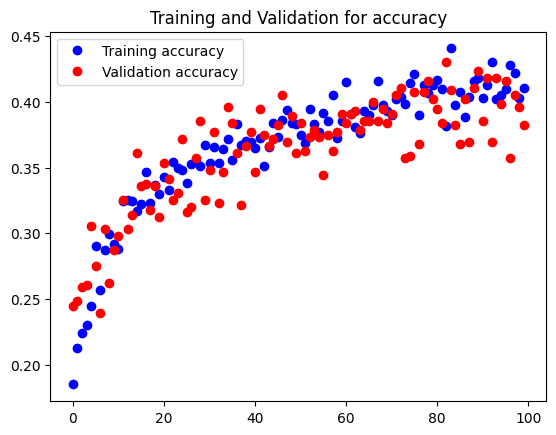

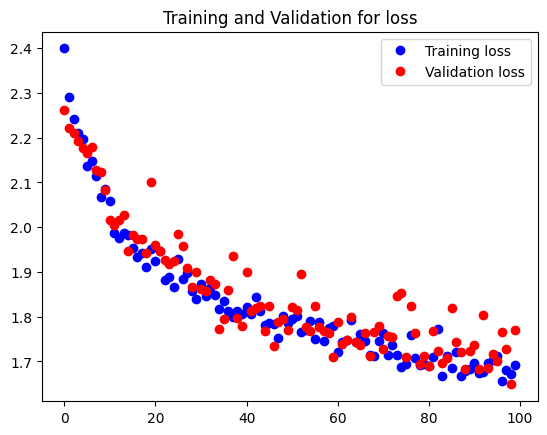

In [15]:
 #Plotting Metrics Curve
#Plotting LOSS and ACCURACY
plots = ['accuracy',  'loss']
for plot in plots:
    metric = history.history[plot]
    val_metric = history.history[f"val_{plot}"]

    epochs = range(len(metric))
  
    #plt.figure(figsize=(10, 10))
    plt.plot(epochs, metric,'bo', label=f"Training {plot}")
    plt.plot(epochs, val_metric,'ro', label=f"Validation {plot}")
    plt.legend()
    plt.title(f"Training and Validation for {plot}")
    plt.show()

In [16]:
# Evaluate accuracy on validation data
validation_accuracy = model1.evaluate(valid_generator)[1]
print(f'Validation accuracy: {validation_accuracy:.4f}')

13/13 [==============================] - 18s 1s/step - loss: 1.8021 - accuracy: 0.3857
Validation accuracy: 0.3857


In [17]:
# Evaluate accuracy on validation data
train_accuracy = model1.evaluate(train_generator)[1]
print(f'Training accuracy: {train_accuracy:.4f}')

50/50 [==============================] - 73s 1s/step - loss: 1.6939 - accuracy: 0.4118
Training accuracy: 0.4118


<h1 class="alert-info">
Baseline 2
</h1>


In [18]:
# Load the baseline 2 model: VGG16 pre-trained model 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [19]:
# Adding custom classification layers on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(n_classes, activation='softmax')(x)

In [20]:
# preparing the VGG-16 model
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False



In [21]:
# Compile the baseline 2 model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)


In [22]:
# Train the model
history_b = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //100,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 100
)

Epoch 1/100
34/34 [==============================] - 111s 3s/step - loss: 2.1541 - accuracy: 0.3094 - val_loss: 1.6717 - val_accuracy: 0.4214
Epoch 2/100
34/34 [==============================] - 108s 3s/step - loss: 1.6179 - accuracy: 0.4599 - val_loss: 1.4717 - val_accuracy: 0.5071
Epoch 3/100
34/34 [==============================] - 109s 3s/step - loss: 1.4824 - accuracy: 0.4983 - val_loss: 1.3725 - val_accuracy: 0.5500
Epoch 4/100
34/34 [==============================] - 112s 3s/step - loss: 1.3989 - accuracy: 0.5332 - val_loss: 1.3375 - val_accuracy: 0.5482
Epoch 5/100
34/34 [==============================] - 109s 3s/step - loss: 1.3183 - accuracy: 0.5483 - val_loss: 1.3430 - val_accuracy: 0.5571
Epoch 6/100
34/34 [==============================] - 108s 3s/step - loss: 1.2846 - accuracy: 0.5632 - val_loss: 1.2664 - val_accuracy: 0.5696
Epoch 7/100
34/34 [==============================] - 109s 3s/step - loss: 1.2281 - accuracy: 0.5852 - val_loss: 1.3317 - val_accuracy: 0.5214
Epoch 

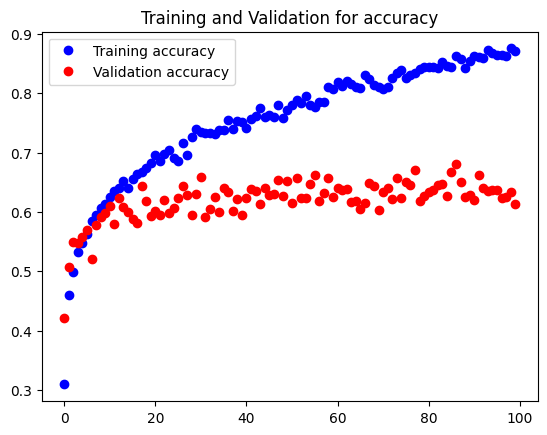

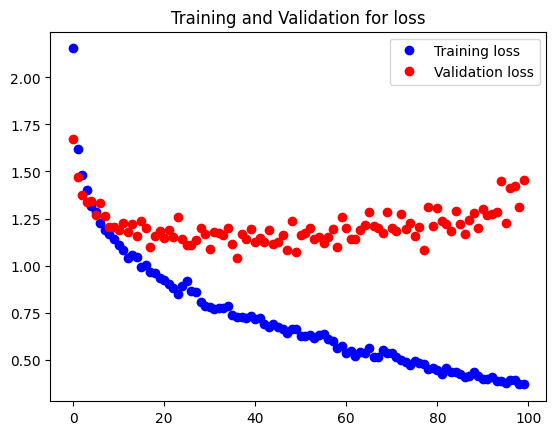

In [23]:
#Plotting Metrics Curve
#Plotting LOSS and ACCURACY
plots = ['accuracy',  'loss']
for plot in plots:
    metric = history_b.history[plot]
    val_metric = history_b.history[f"val_{plot}"]

    epochs = range(len(metric))
  
    #plt.figure(figsize=(10, 10))
    plt.plot(epochs, metric,'bo', label=f"Training {plot}")
    plt.plot(epochs, val_metric,'ro', label=f"Validation {plot}")
    plt.legend()
    plt.title(f"Training and Validation for {plot}")
    plt.show()

In [24]:
# Evaluate accuracy on validation data
validation_accuracy = model.evaluate(valid_generator)[1]
print(f'Validation accuracy: {validation_accuracy:.4f}')

13/13 [==============================] - 37s 3s/step - loss: 1.3954 - accuracy: 0.6328
Validation accuracy: 0.6328


In [25]:
# Evaluate accuracy on validation data
train_accuracy = model.evaluate(train_generator)[1]
print(f'Training accuracy: {train_accuracy:.4f}')

50/50 [==============================] - 149s 3s/step - loss: 0.1885 - accuracy: 0.9433
Training accuracy: 0.9433


<h1 class="alert-info">
    Prototype 1:Overfit
</h1>


In [26]:
#overfit
#Building the model
overfit_model = Sequential([
     #Conv2D layer
     tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
     #Max-pooling layer 1
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Conv2D layer
     tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    #Max-pooling layer 2
     tf.keras.layers.MaxPooling2D(pool_size=2),
    #Flatten layer
     tf.keras.layers.Flatten(),
    #Dense layer 1
     tf.keras.layers.Dense(units=10, activation='softmax'),
    #Dense layer 2
     tf.keras.layers.Dense(n_classes, activation='softmax')
])
  

In [27]:
# Compiling the model
overfit_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
#Composing the model
overfit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7744)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                7

In [29]:
#training the overfit model
NUM_EPOCHS = 200
history1 = overfit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //100 ,
    epochs=NUM_EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 100
)


Epoch 1/200
34/34 [==============================] - 43s 1s/step - loss: 2.4966 - accuracy: 0.1945 - val_loss: 2.4950 - val_accuracy: 0.1732
Epoch 2/200
34/34 [==============================] - 39s 1s/step - loss: 2.4704 - accuracy: 0.1965 - val_loss: 2.4500 - val_accuracy: 0.2071
Epoch 3/200
34/34 [==============================] - 40s 1s/step - loss: 2.4414 - accuracy: 0.1945 - val_loss: 2.4327 - val_accuracy: 0.1857
Epoch 4/200
34/34 [==============================] - 39s 1s/step - loss: 2.4161 - accuracy: 0.2024 - val_loss: 2.4133 - val_accuracy: 0.1929
Epoch 5/200
34/34 [==============================] - 44s 1s/step - loss: 2.4052 - accuracy: 0.2015 - val_loss: 2.3921 - val_accuracy: 0.2161
Epoch 6/200
34/34 [==============================] - 48s 1s/step - loss: 2.3602 - accuracy: 0.2209 - val_loss: 2.3780 - val_accuracy: 0.1929
Epoch 7/200
34/34 [==============================] - 47s 1s/step - loss: 2.3386 - accuracy: 0.2180 - val_loss: 2.3492 - val_accuracy: 0.2000
Epoch 8/200
3

Epoch 59/200
34/34 [==============================] - 40s 1s/step - loss: 1.9172 - accuracy: 0.3461 - val_loss: 2.0041 - val_accuracy: 0.3429
Epoch 60/200
34/34 [==============================] - 40s 1s/step - loss: 1.8771 - accuracy: 0.3794 - val_loss: 2.0071 - val_accuracy: 0.3161
Epoch 61/200
34/34 [==============================] - 40s 1s/step - loss: 1.8955 - accuracy: 0.3626 - val_loss: 2.0084 - val_accuracy: 0.3304
Epoch 62/200
34/34 [==============================] - 40s 1s/step - loss: 1.8820 - accuracy: 0.3681 - val_loss: 1.9629 - val_accuracy: 0.3607
Epoch 63/200
34/34 [==============================] - 39s 1s/step - loss: 1.8817 - accuracy: 0.3647 - val_loss: 1.9958 - val_accuracy: 0.3214
Epoch 64/200
34/34 [==============================] - 39s 1s/step - loss: 1.8890 - accuracy: 0.3634 - val_loss: 2.0064 - val_accuracy: 0.3268
Epoch 65/200
34/34 [==============================] - 39s 1s/step - loss: 1.8808 - accuracy: 0.3597 - val_loss: 1.9798 - val_accuracy: 0.3321
Epoch 

34/34 [==============================] - 39s 1s/step - loss: 1.2577 - accuracy: 0.5556 - val_loss: 1.9932 - val_accuracy: 0.3643
Epoch 174/200
34/34 [==============================] - 39s 1s/step - loss: 1.2355 - accuracy: 0.5565 - val_loss: 1.8999 - val_accuracy: 0.3964
Epoch 175/200
34/34 [==============================] - 40s 1s/step - loss: 1.2444 - accuracy: 0.5523 - val_loss: 2.0587 - val_accuracy: 0.3589
Epoch 176/200
34/34 [==============================] - 39s 1s/step - loss: 1.2485 - accuracy: 0.5508 - val_loss: 1.9939 - val_accuracy: 0.3786
Epoch 177/200
34/34 [==============================] - 40s 1s/step - loss: 1.2603 - accuracy: 0.5451 - val_loss: 2.0330 - val_accuracy: 0.3661
Epoch 178/200
34/34 [==============================] - 39s 1s/step - loss: 1.2408 - accuracy: 0.5624 - val_loss: 1.9853 - val_accuracy: 0.3839
Epoch 179/200
34/34 [==============================] - 39s 1s/step - loss: 1.2046 - accuracy: 0.5662 - val_loss: 1.9579 - val_accuracy: 0.4000
Epoch 180/200

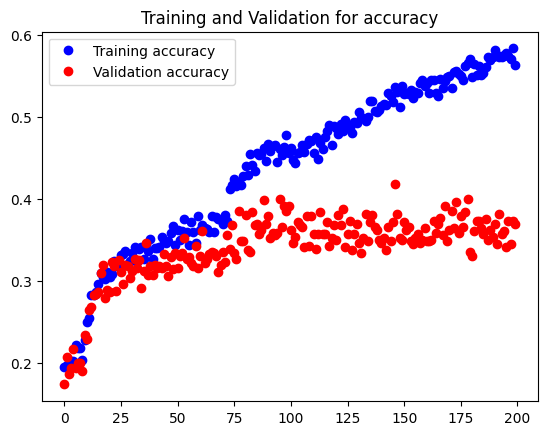

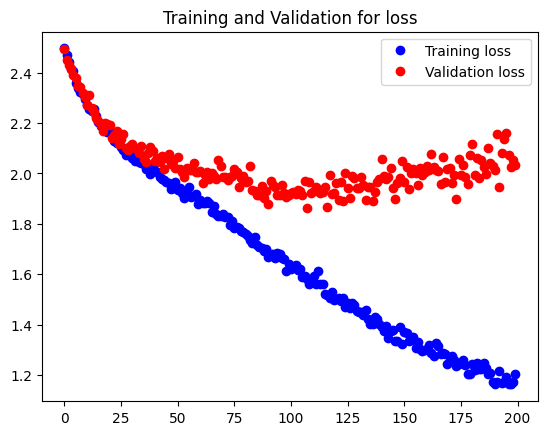

In [30]:
# Plotting Metrics Curve
#Plotting LOSS and ACCURACY
plots = ['accuracy',  'loss']
for plot in plots:
    metric = history1.history[plot]
    val_metric = history1.history[f"val_{plot}"]

    epochs = range(len(metric))
  
    #plt.figure(figsize=(10, 10))
    plt.plot(epochs, metric,'bo', label=f"Training {plot}")
    plt.plot(epochs, val_metric,'ro', label=f"Validation {plot}")
    plt.legend()
    plt.title(f"Training and Validation for {plot}")
    plt.show()

In [31]:
# Evaluate accuracy on validation data
validation_accuracy = overfit_model.evaluate(valid_generator)[1]
print(f'Validation accuracy: {validation_accuracy:.4f}')

13/13 [==============================] - 10s 769ms/step - loss: 2.1128 - accuracy: 0.3545
Validation accuracy: 0.3545


In [32]:
# Evaluate accuracy on validation data
train_accuracy = overfit_model.evaluate(train_generator)[1]
print(f'Training accuracy: {train_accuracy:.4f}')

50/50 [==============================] - 43s 862ms/step - loss: 1.1464 - accuracy: 0.5839
Training accuracy: 0.5839


<h1 class="alert-info">
    Prototype 2:Underfit
</h1>


In [33]:
#Underfit
# Building the underfit model
from tensorflow.keras.regularizers import l1_l2

underfit_model = tf.keras.Sequential([
    #conv2D layer
     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu'),
    #Max-pooling layer 1
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Con2D layer
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    #Max-pooling layer 2
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Conv2D layer
     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Flatten layer
     tf.keras.layers.Flatten(),
    #Dropout layer 1
     tf.keras.layers.Dropout(0.20),
    #Dense layer 1
     tf.keras.layers.Dense(512, activation='relu'),
    #Dense layer 2
     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01)),
    #Dropout layer 2
     tf.keras.layers.Dropout(0.50),
    #Dense layer 3
     tf.keras.layers.Dense(n_classes, activation='softmax')

])

In [34]:
# Compiling the model
underfit_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [35]:
#Composing the model
underfit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                  

In [36]:
#Training the underfit model
NUM_EPOCHS = 200
history_u = underfit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // NUM_EPOCHS,
    epochs=NUM_EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//NUM_EPOCHS,
     callbacks=[early_stop],
)


Epoch 1/200
17/17 [==============================] - 25s 1s/step - loss: 30.8597 - accuracy: 0.2101 - val_loss: 25.2477 - val_accuracy: 0.2750
Epoch 2/200
17/17 [==============================] - 22s 1s/step - loss: 21.0432 - accuracy: 0.2284 - val_loss: 16.6380 - val_accuracy: 0.2500
Epoch 3/200
17/17 [==============================] - 23s 1s/step - loss: 13.5592 - accuracy: 0.2387 - val_loss: 10.4360 - val_accuracy: 0.2286
Epoch 4/200
17/17 [==============================] - 22s 1s/step - loss: 8.2120 - accuracy: 0.2471 - val_loss: 6.0478 - val_accuracy: 0.2607
Epoch 5/200
17/17 [==============================] - 22s 1s/step - loss: 4.7399 - accuracy: 0.2647 - val_loss: 3.5922 - val_accuracy: 0.3214
Epoch 6/200
17/17 [==============================] - 23s 1s/step - loss: 3.0614 - accuracy: 0.2899 - val_loss: 2.7746 - val_accuracy: 0.3250
Epoch 7/200
17/17 [==============================] - 22s 1s/step - loss: 2.6379 - accuracy: 0.2851 - val_loss: 2.4527 - val_accuracy: 0.3357
Epoch 8

Epoch 59/200
17/17 [==============================] - 22s 1s/step - loss: 1.7434 - accuracy: 0.4891 - val_loss: 1.8301 - val_accuracy: 0.4393
Epoch 59: early stopping


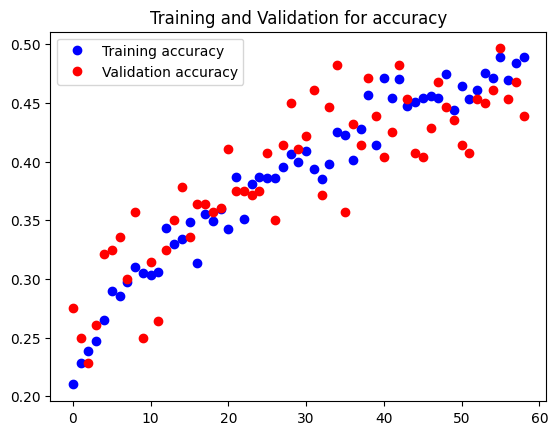

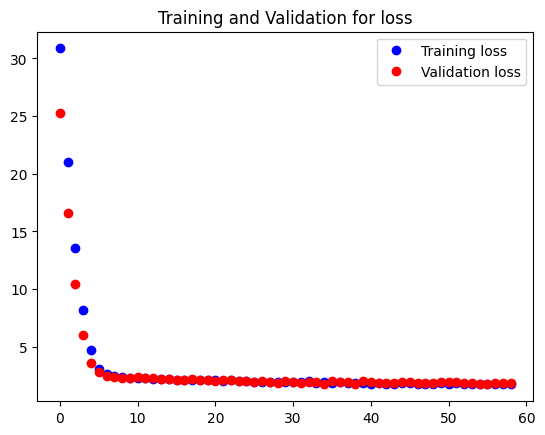

In [37]:
# Plotting Metrics Curve
#Plotting LOSS and ACCURACY
plots = ['accuracy',  'loss']
for plot in plots:
    metric = history_u.history[plot]
    val_metric = history_u.history[f"val_{plot}"]

    epochs = range(len(metric))
  
    #plt.figure(figsize=(10, 10))
    plt.plot(epochs, metric,'bo', label=f"Training {plot}")
    plt.plot(epochs, val_metric,'ro', label=f"Validation {plot}")
    plt.legend()
    plt.title(f"Training and Validation for {plot}")
    plt.show()

In [38]:
# Evaluate accuracy on validation data
validation_accuracy = underfit_model.evaluate(valid_generator)[1]
print(f'Validation accuracy: {validation_accuracy:.4f}')

13/13 [==============================] - 10s 791ms/step - loss: 1.8942 - accuracy: 0.4342
Validation accuracy: 0.4342


In [39]:
# Evaluate accuracy on validation data
train_accuracy = underfit_model.evaluate(train_generator)[1]
print(f'Training accuracy: {train_accuracy:.4f}')

50/50 [==============================] - 43s 856ms/step - loss: 1.7441 - accuracy: 0.4734
Training accuracy: 0.4734


<h1 class="alert-info">
    Prototype 3:Optimal
</h1>


In [40]:
# Build the optimal model
from tensorflow.keras.regularizers import l1_l2

#optimal cnn modle
optimal_model1 = tf.keras.Sequential([
    #Conv2D layer  
     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu'),
    #Max-pooling 1
     tf.keras.layers.MaxPooling2D((2, 2)),
    #COnv2D layer 
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    #Max-pooling 2
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Conv2D layer
     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    #Max-pooling layer 3
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Conv2D layer
     tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    #Max-pooling layer 4
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Conv2D layer
     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',activation ='relu'),
     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    #Max-pooling layer 5
     tf.keras.layers.MaxPooling2D((2, 2)),
    #Flatten layer
     tf.keras.layers.Flatten(),
    #Dropout layer
     tf.keras.layers.Dropout(0.50),
    #Dense layer 1
     tf.keras.layers.Dense(128, activation='relu',kernel_regularizer='l2'),
    #Dense layer 2
     tf.keras.layers.Dense(512, activation='relu'),
    #Dense layer 3
     tf.keras.layers.Dense(n_classes, activation='softmax')

])

In [41]:
#Summary of the model
optimal_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 42, 42, 32)        9248      
                                                      

In [42]:
#Compile the layer
optimizer = Adam(lr=0.0001)
optimal_model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [43]:
#Training the model
NUM_EPOCHS = 300
history_p = optimal_model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // NUM_EPOCHS,
    epochs=300,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//NUM_EPOCHS,

)


Epoch 1/300
17/17 [==============================] - 30s 2s/step - loss: 4.7567 - accuracy: 0.1580 - val_loss: 4.5865 - val_accuracy: 0.2107
Epoch 2/300
17/17 [==============================] - 26s 2s/step - loss: 4.4873 - accuracy: 0.1891 - val_loss: 4.4053 - val_accuracy: 0.2250
Epoch 3/300
17/17 [==============================] - 26s 2s/step - loss: 4.3220 - accuracy: 0.1798 - val_loss: 4.2578 - val_accuracy: 0.1964
Epoch 4/300
17/17 [==============================] - 27s 2s/step - loss: 4.1823 - accuracy: 0.1971 - val_loss: 4.0857 - val_accuracy: 0.2286
Epoch 5/300
17/17 [==============================] - 26s 2s/step - loss: 4.0649 - accuracy: 0.1988 - val_loss: 4.0349 - val_accuracy: 0.2071
Epoch 6/300
17/17 [==============================] - 26s 2s/step - loss: 3.9381 - accuracy: 0.2017 - val_loss: 3.9236 - val_accuracy: 0.2107
Epoch 7/300
17/17 [==============================] - 27s 2s/step - loss: 3.8484 - accuracy: 0.1941 - val_loss: 3.8141 - val_accuracy: 0.2036
Epoch 8/300
1

Epoch 59/300
17/17 [==============================] - 26s 2s/step - loss: 1.9895 - accuracy: 0.4289 - val_loss: 2.1833 - val_accuracy: 0.3393
Epoch 60/300
17/17 [==============================] - 27s 2s/step - loss: 1.9309 - accuracy: 0.4315 - val_loss: 2.0006 - val_accuracy: 0.4357
Epoch 61/300
17/17 [==============================] - 31s 2s/step - loss: 1.9009 - accuracy: 0.4467 - val_loss: 2.0131 - val_accuracy: 0.4286
Epoch 62/300
17/17 [==============================] - 30s 2s/step - loss: 1.8815 - accuracy: 0.4429 - val_loss: 1.9900 - val_accuracy: 0.4357
Epoch 63/300
17/17 [==============================] - 27s 2s/step - loss: 1.8978 - accuracy: 0.4412 - val_loss: 2.0418 - val_accuracy: 0.4036
Epoch 64/300
17/17 [==============================] - 28s 2s/step - loss: 1.9263 - accuracy: 0.4143 - val_loss: 2.0636 - val_accuracy: 0.3857
Epoch 65/300
17/17 [==============================] - 28s 2s/step - loss: 1.9386 - accuracy: 0.4294 - val_loss: 2.0732 - val_accuracy: 0.3893
Epoch 

17/17 [==============================] - 34s 2s/step - loss: 1.3070 - accuracy: 0.5736 - val_loss: 1.6263 - val_accuracy: 0.4857
Epoch 174/300
17/17 [==============================] - 30s 2s/step - loss: 1.3100 - accuracy: 0.5753 - val_loss: 1.5653 - val_accuracy: 0.4607
Epoch 175/300
17/17 [==============================] - 32s 2s/step - loss: 1.3496 - accuracy: 0.5521 - val_loss: 1.5669 - val_accuracy: 0.5071
Epoch 176/300
17/17 [==============================] - 34s 2s/step - loss: 1.3251 - accuracy: 0.5643 - val_loss: 1.6845 - val_accuracy: 0.4536
Epoch 177/300
17/17 [==============================] - 34s 2s/step - loss: 1.3838 - accuracy: 0.5516 - val_loss: 1.5563 - val_accuracy: 0.5214
Epoch 178/300
17/17 [==============================] - 33s 2s/step - loss: 1.2580 - accuracy: 0.5981 - val_loss: 1.6301 - val_accuracy: 0.4786
Epoch 179/300
17/17 [==============================] - 30s 2s/step - loss: 1.3470 - accuracy: 0.5496 - val_loss: 1.4773 - val_accuracy: 0.4964
Epoch 180/300

17/17 [==============================] - 33s 2s/step - loss: 1.0883 - accuracy: 0.6462 - val_loss: 1.5087 - val_accuracy: 0.5214
Epoch 288/300
17/17 [==============================] - 30s 2s/step - loss: 1.0817 - accuracy: 0.6412 - val_loss: 1.5941 - val_accuracy: 0.4964
Epoch 289/300
17/17 [==============================] - 32s 2s/step - loss: 1.0296 - accuracy: 0.6675 - val_loss: 1.4965 - val_accuracy: 0.5571
Epoch 290/300
17/17 [==============================] - 32s 2s/step - loss: 1.0498 - accuracy: 0.6472 - val_loss: 1.4825 - val_accuracy: 0.5857
Epoch 291/300
17/17 [==============================] - 30s 2s/step - loss: 1.0610 - accuracy: 0.6607 - val_loss: 1.3843 - val_accuracy: 0.5536
Epoch 292/300
17/17 [==============================] - 30s 2s/step - loss: 1.0438 - accuracy: 0.6613 - val_loss: 1.6437 - val_accuracy: 0.4929
Epoch 293/300
17/17 [==============================] - 31s 2s/step - loss: 1.0620 - accuracy: 0.6588 - val_loss: 1.4740 - val_accuracy: 0.5357
Epoch 294/300

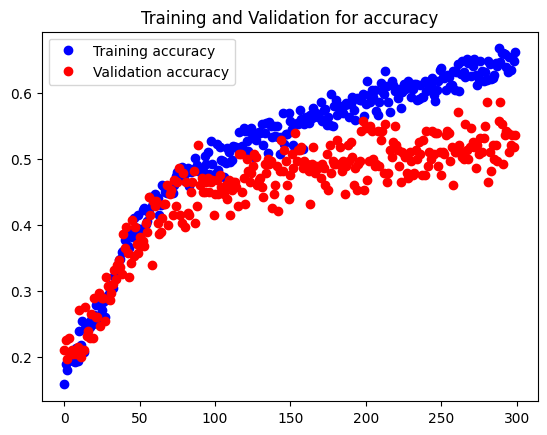

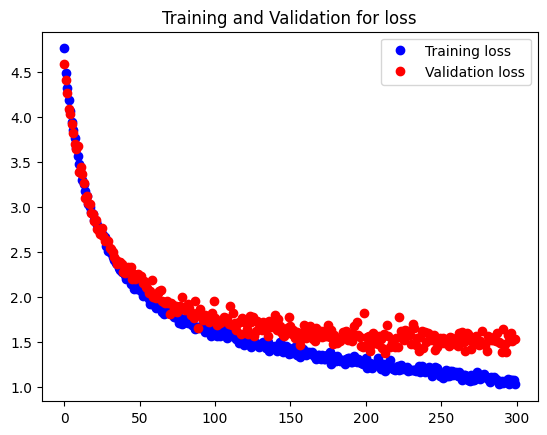

In [44]:
# Plotting Metrics Curve
#Plotting LOSS and ACCURACY
plots = ['accuracy',  'loss']
for plot in plots:
    metric = history_p.history[plot]
    val_metric = history_p.history[f"val_{plot}"]

    epochs = range(len(metric))
  
    #plt.figure(figsize=(10, 10))
    plt.plot(epochs, metric,'bo', label=f"Training {plot}")
    plt.plot(epochs, val_metric,'ro', label=f"Validation {plot}")
    plt.legend()
    plt.title(f"Training and Validation for {plot}")
    plt.show()

In [45]:
# Evaluate accuracy on validation data
validation_accuracy = optimal_model1.evaluate(valid_generator)[1]
print(f'Validation accuracy: {validation_accuracy:.4f}')

13/13 [==============================] - 14s 1s/step - loss: 1.5074 - accuracy: 0.5289
Validation accuracy: 0.5289


In [46]:
# Evaluate accuracy on validation data
validation_accuracy = optimal_model1.evaluate(train_generator)[1]
print(f'Training accuracy: {validation_accuracy:.4f}')

50/50 [==============================] - 54s 1s/step - loss: 0.9923 - accuracy: 0.6698
Training accuracy: 0.6698


In [90]:
# Predicted probabilities
predicted_probabilities = optimal_model1.predict(train_generator)

# Probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# True values
true_labels = train_generator.classes


50/50 [==============================] - 36s 708ms/step


<h1 class="alert-info">
   Confusion Matrix
</h1>


In [116]:
# Computing confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels )


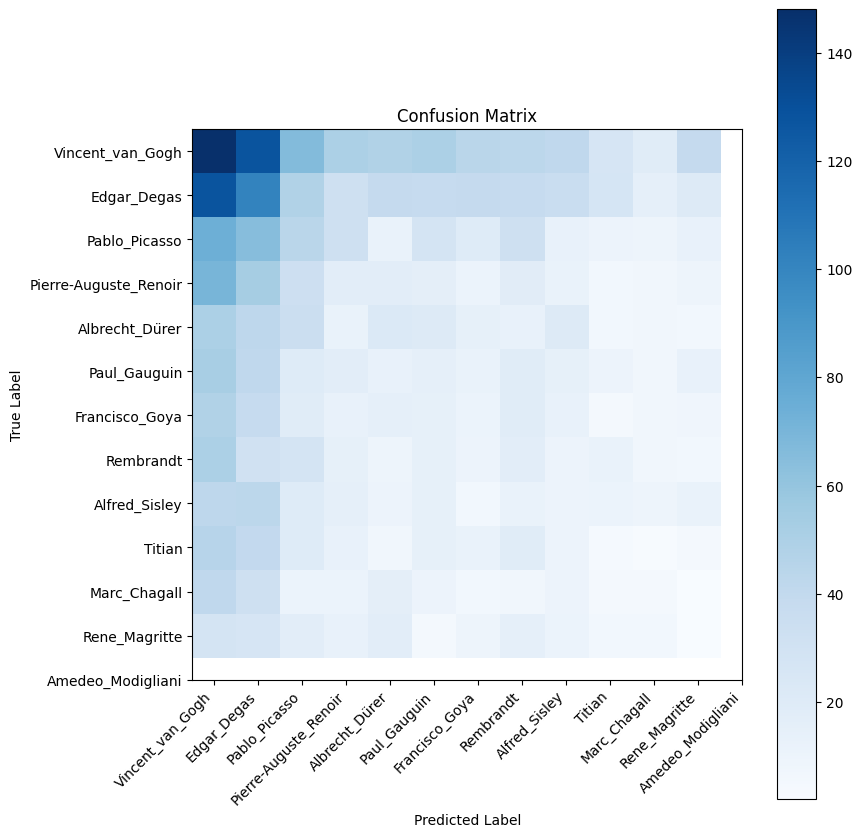

In [117]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(artists_top_name))
plt.xticks(tick_marks, artists_top_name, rotation=45, ha="right")  
plt.yticks(tick_marks, artists_top_name)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [120]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Weighted Precision: {precision:.4f}')


Accuracy: 0.6615
Weighted Precision: 0.6743


###### 